# Counting Boats from Space - Part 2

In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
%matplotlib inline

## 1. Install, Import requirements

In [2]:
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install plotly

In [3]:
# Various utilities
import os
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage
import torch
from torch.utils.data import DataLoader

In [4]:
from src.dataset import getImageSetDirectories, S2_Dataset, plot_dataset
from src.model import Model
from src.train import train, get_failures_or_success

In [5]:
torch.cuda.is_available() # gpu support

False

## 2. Init K-Fold Dataset

In [6]:
data_dir = "/home/jovyan/data" # data directory (path)
checkpoint_dir = "/home/jovyan/checkpoints"
bands = ['img_08', 'bg_ndwi']
test_size = 0.2

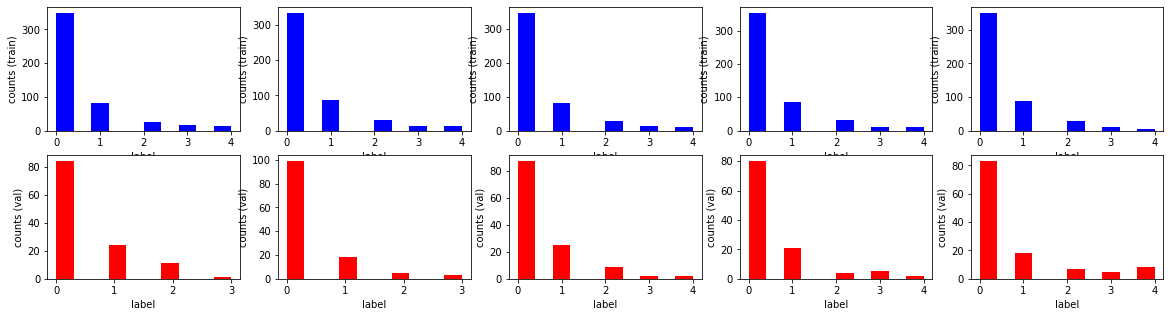

In [7]:
train_list, val_list, fig = getImageSetDirectories(data_dir=os.path.join(data_dir, 'chips'), band_list=bands, test_size=test_size, plot_coords=False, plot_class_imbalance=True, use_KFold=True, seed=123)
fig # mapbox plot train/val coordinates

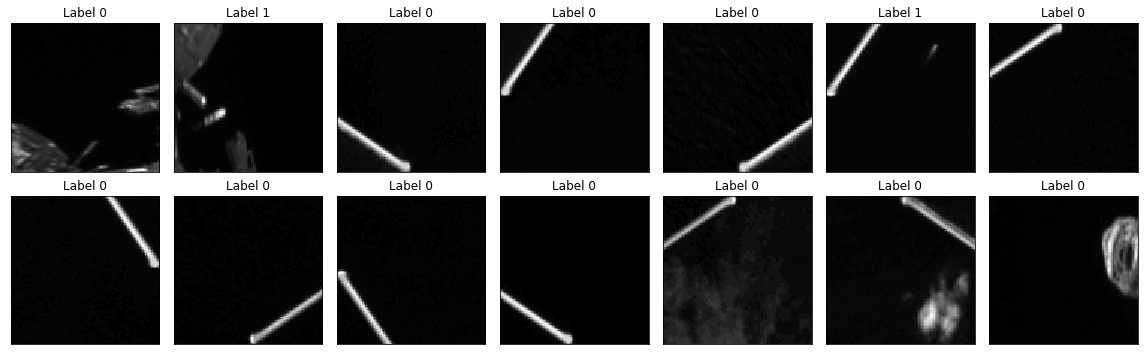

In [8]:
train_dataset = S2_Dataset(imset_dir=train_list[0], augment=True)
val_dataset = S2_Dataset(imset_dir=val_list[0], augment=False)
plot_dataset(train_dataset, n_frames=14, n_rows=2, cmap='gray')

## 4. Train PyTorch Classifier

In [9]:
##### TODO: Add / report metrics (precision, recall, F1, etc.) for boat presence + counts

In [10]:
# training config
input_dim = train_dataset[0]['img'].shape[0]
hidden_dim, kernel_size, pool_size, n_max = 16, 3, 10, 1

In [ ]:
K_fold_metrics = []
for fold, (train_imset, val_imset) in enumerate(zip(train_list, val_list)):
    train_dataset = S2_Dataset(imset_dir=train_imset, augment=True)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=16)
    
    val_dataset = S2_Dataset(imset_dir=val_imset, augment=False)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

    best_metrics = train(train_dataloader=train_dataloader, val_dataloader=val_dataloader,
                 input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, pool_size=pool_size, n_max=n_max, drop_proba=0.15,
                 ld=0.2, water_ndwi=0.4,
                 n_epochs=100, lr=0.007, lr_step=2, lr_decay=0.95,
                 device='cpu', checkpoints_dir=checkpoint_dir, seed=fold, verbose=1, fold=fold)
    
    K_fold_metrics.append(best_metrics)

In [12]:
# Epoch 62: train_clf_error 0.11637 / train_reg_error 0.15685 / val_clf_error 0.02619 / val_reg_error 0.08079

In [13]:
print('MAX:  train_clf_error {:.4f} / train_reg_error {:.4f} / val_clf_error {:.4f} / val_reg_error {:.4f} '.format(
    np.max([metrics['train_clf_error'] for metrics in K_fold_metrics]), np.max([metrics['train_reg_error'] for metrics in K_fold_metrics]),
    np.max([metrics['val_clf_error'] for metrics in K_fold_metrics]), np.max([metrics['val_reg_error'] for metrics in K_fold_metrics])))

print('MEAN: train_clf_error {:.4f} / train_reg_error {:.4f} / val_clf_error {:.4f} / val_reg_error {:.4f} '.format(
    np.mean([metrics['train_clf_error'] for metrics in K_fold_metrics]), np.mean([metrics['train_reg_error'] for metrics in K_fold_metrics]),
    np.mean([metrics['val_clf_error'] for metrics in K_fold_metrics]), np.mean([metrics['val_reg_error'] for metrics in K_fold_metrics])))

print('MIN:  train_clf_error {:.4f} / train_reg_error {:.4f} / val_clf_error {:.4f} / val_reg_error {:.4f} '.format(
    np.min([metrics['train_clf_error'] for metrics in K_fold_metrics]), np.min([metrics['train_reg_error'] for metrics in K_fold_metrics]),
    np.min([metrics['val_clf_error'] for metrics in K_fold_metrics]), np.min([metrics['val_reg_error'] for metrics in K_fold_metrics])))

MAX:  train_clf_error 0.1662 / train_reg_error 0.1460 / val_clf_error 0.3501 / val_reg_error 0.2600 
MEAN: train_clf_error 0.1139 / train_reg_error 0.1316 / val_clf_error 0.1157 / val_reg_error 0.1415 
MIN:  train_clf_error 0.0529 / train_reg_error 0.0866 / val_clf_error 0.0238 / val_reg_error 0.0376 


In [14]:
print('MEAN:  train_accuracy {:.4f} / train_precision {:.4f} / train_recall {:.4f} / train_f1 {:.4f} '.format(
    np.mean([metrics['train_accuracy'] for metrics in K_fold_metrics]), np.mean([metrics['train_precision'] for metrics in K_fold_metrics]),
    np.mean([metrics['train_recall'] for metrics in K_fold_metrics]), np.mean([metrics['train_f1'] for metrics in K_fold_metrics])))

print('MEAN:  val_accuracy {:.4f} / val_precision {:.4f} / val_recall {:.4f} / val_f1 {:.4f} '.format(
    np.mean([metrics['val_accuracy'] for metrics in K_fold_metrics]), np.mean([metrics['val_precision'] for metrics in K_fold_metrics]),
    np.mean([metrics['val_recall'] for metrics in K_fold_metrics]), np.mean([metrics['val_f1'] for metrics in K_fold_metrics])))

MEAN:  train_accuracy 0.9520 / train_precision 0.8738 / train_recall 0.9018 / train_f1 0.8382 
MEAN:  val_accuracy 0.9625 / val_precision 0.5941 / val_recall 0.9836 / val_f1 0.6174 


## 5. Test Model

In [15]:
top_1_clf = np.argmin([metrics['val_clf_error'] for metrics in K_fold_metrics])
top_1_reg = np.argmin([metrics['val_reg_error'] for metrics in K_fold_metrics])
print('Top 1 Clf (id {}): {:.4f} clf / {:.4f} count'.format(top_1_clf, K_fold_metrics[top_1_clf]['val_clf_error'], K_fold_metrics[top_1_clf]['val_reg_error']))
print('Top 1 Reg (id {}): {:.4f} clf / {:.4f} count'.format(top_1_reg, K_fold_metrics[top_1_reg]['val_clf_error'], K_fold_metrics[top_1_reg]['val_reg_error']))

Top 1 Clf (id 1): 0.0238 clf / 0.0376 count
Top 1 Reg (id 1): 0.0238 clf / 0.0376 count


In [12]:
# load pretrained model
model = Model(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, pool_size=pool_size, n_max=n_max, device='cpu', fold=top_1_clf)
checkpoint_file = os.path.join(checkpoint_dir, model.folder, 'model.pth')
model.load_checkpoint(checkpoint_file=checkpoint_file)
model = model.eval()

In [ ]:
##### Display failures (train, val) and inspect hidden channels --> Re label?
get_failures_or_success(model, val_dataset, hidden_channel=1, success=False, filter_on=1)  # 13, 11, 10, 3